In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

In [4]:
#!pip install --upgrade scikit-learn xgboost


In [5]:
#IMDb Movie Reviews Dataset
data = pd.read_csv('IMDB Dataset.csv')

# Exploratory Data Analysis (EDA)

In [6]:
print(data.head())
print(data.info())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [7]:
print(data['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Longer reviews might carry more sentiment information, while shorter ones might be harder to classify.

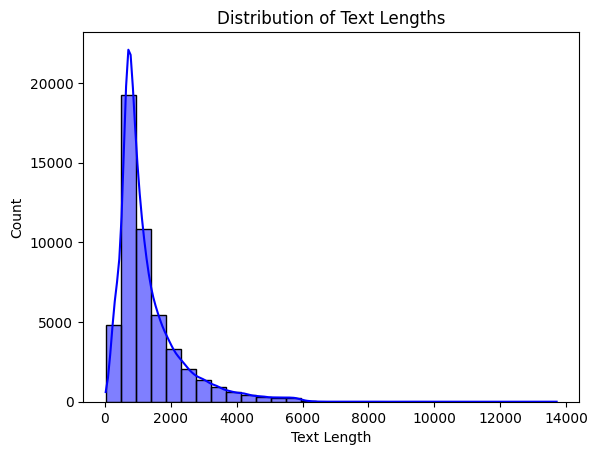

In [8]:
data['text_length'] = data['review'].apply(len)

sns.histplot(data['text_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


In [9]:
def most_freq_words(data_col):
  # Most frequent words in positive reviews
  positive_words = ' '.join(data[data['sentiment'] == 'positive'][data_col]).split()
  positive_word_freq = Counter(positive_words).most_common(10)

  # Most frequent words in negative reviews
  negative_words = ' '.join(data[data['sentiment'] == 'negative'][data_col]).split()
  negative_word_freq = Counter(negative_words).most_common(10)

  return (print('Top 10 Words in Positive Reviews:', positive_word_freq),
          print('Top 10 Words in Negative Reviews:', negative_word_freq))

In [10]:
def word_cloud(data_col):
  # Positive reviews word cloud
  positive_text = ' '.join(data[data['sentiment'] == 'positive'][data_col])
  positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(positive_wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud for Positive Reviews')
  plt.show()

  # Negative reviews word cloud
  negative_text = ' '.join(data[data['sentiment'] == 'negative'][data_col])
  negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(negative_wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud for Negative Reviews')
  plt.show()

# Visualization functions

In [11]:
def plot_learning_curves(model,X,y,title,xlabel,ylabel):
  # Plot learning curves
  train_sizes, train_scores, test_scores = learning_curve(
      estimator=model,
      X=X,
      y=y,
      cv=5,
      train_sizes=np.linspace(0.1, 1.0, 5),
      scoring='accuracy',
      n_jobs=-1
  )

  # Calculate means and standard deviations
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  # Plot the learning curve
  plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training accuracy')
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
  plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation accuracy')
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc='best')
  plt.grid()
  plt.show()

# Data Pre-Processing

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

# Download necessary NLTK resources
nltk.download('stopwords') # Stopwords list
nltk.download('punkt') # Tokenizer models
nltk.download('punkt_tab')

# Load stopwords
stop_words = set(stopwords.words('english')) - {'not', 'never'}

# Remove neutral words that appear often in both reviews
neutral_words = {} #{'movie', 'film', 'one', 'time', 'story', 'would', 'see', 'even', 'really'}

# Preprocessing pipeline
def preprocess_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Tokenize, remove non-alphabetic words, convert to lowercase, and filter out stopwords and neutral words
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words and word.lower() not in neutral_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to the dataset
data['cleaned_text'] = data['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-12-e81b3112ebfc>:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [13]:
# Comparing original data and data after pre-processing

print(f"Review: {data['review'][1]}")
print(f"Cleaned text: {data['cleaned_text'][1]}")

Review: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well

In [14]:
most_freq_words('cleaned_text')

Top 10 Words in Positive Reviews: [('film', 40772), ('movie', 36699), ('not', 28926), ('one', 26197), ('like', 17144), ('good', 14452), ('great', 12736), ('story', 12516), ('see', 11917), ('time', 11871)]
Top 10 Words in Negative Reviews: [('movie', 48355), ('film', 36156), ('not', 33067), ('one', 25026), ('like', 21875), ('would', 15211), ('even', 15048), ('good', 14232), ('bad', 14174), ('really', 12284)]


(None, None)

# Prepare data to fit the model

In [15]:
# Split dataset into training and dataset
x = data['cleaned_text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# one-hot-encoded y:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [16]:
print(f"X_train, X_test sizes: {X_train.size}, {X_test.size}")
print(f"y_train, y_test sizes: {y_train.size}, {y_test.size}")

X_train, X_test sizes: 40000, 10000
y_train, y_test sizes: 40000, 10000


# Logistic Regression with CountVectorizer

In [17]:
# Data using CountVectorizer:
# Convert text data into feature matrices using CountVectorizer
vectorizer = CountVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

In [18]:
# Instantiate the Logistic Regression model
log_reg_CV = LogisticRegression(solver='liblinear')

# Train the model
log_reg_CV.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = log_reg_CV.predict(X_test_features)

In [19]:
# Evaluate the model
accuracy_CV = accuracy_score(y_test, y_pred)
classification_rep_CV = classification_report(y_test, y_pred)

print("Accuracy CountVectorizer:", accuracy_CV)

print("\nClassification Report CountVectorizer:\n", classification_rep_CV)

Accuracy CountVectorizer: 0.884

Classification Report CountVectorizer:
               precision    recall  f1-score   support

    negative       0.89      0.88      0.88      4961
    positive       0.88      0.89      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## How is my the model doing in terms of overfitting (High Variance) / underfitting (High Bias)?

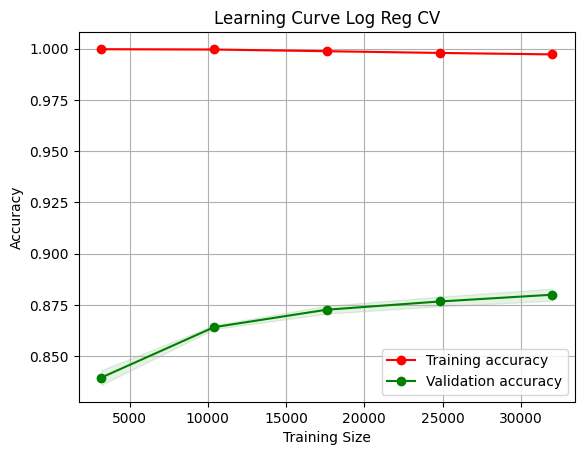

In [20]:
plot_learning_curves(log_reg_CV,
                     X_train_features,
                     y_train,
                     'Learning Curve Log Reg CV',
                     'Training Size',
                     'Accuracy')

In [21]:
feature_names = vectorizer.get_feature_names_out()

# Calculate the sum of each word's frequency across all documents
word_counts = X_train_features.sum(axis=0).A1  # Convert sparse matrix to a dense array

# Pair each word with its frequency
word_freq = list(zip(feature_names, word_counts))

# Sort the pairs by frequency in descending order
sorted_word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

# Display the top N words
top_n = 10
print(f"Top {top_n} Words:")
for word, freq in sorted_word_freq[:top_n]:
    print(f"{word}: {freq}")

Top 10 Words:
movie: 67825
film: 61562
not: 49746
one: 41065
like: 31158
good: 22853
would: 21191
even: 19547
time: 18815
really: 18350


**Results analysis:**
Very big gap between validation and training accuracy, it means the model is probably overfitting and not generalizing well.
The top words considered by the model are not very helpful, which means the pre-processing approach was not the best.
Next step will be trying the TF-IDF method which gives meaninful words higher weight.

# Logistic Regression with TF-IDF (Term Frequency-Inverse Document Frequency)
My next step will be changing the vectorizing method and analysing how much this could improve my logistic regression perfomance.

In [22]:
# Vectorizing with TF-IDF:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary size (adjust as needed)
    ngram_range=(1, 2,),  # Use unigrams and bigrams
    stop_words='english',  # Remove standard stopwords (optional, since I've already handled this)
)

# Transform the text data into TF-IDF feature matrices
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [23]:
# Instantiate and train the Logistic Regression model
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_test = log_reg.predict(X_test_tfidf)

In [24]:
# View the most important features (words/phrases) learned by the model
feature_names = tfidf_vectorizer.get_feature_names_out()
sorted_coefficients = sorted(
    zip(log_reg.coef_[0], feature_names),
    key=lambda x: x[0],
    reverse=True
)
print("\nTop Positive Words:")
for coef, word in sorted_coefficients[:10]:
    print(word, coef)

print("\nTop Negative Words:")
for coef, word in sorted_coefficients[-10:]:
    print(word, coef)


Top Positive Words:
excellent 6.686424905336947
great 6.633435429466556
best 4.95592690176177
wonderful 4.939452901094443
perfect 4.890506489979372
amazing 4.884906570408245
brilliant 4.570431964298382
favorite 4.399805668075623
hilarious 4.194256897021183
loved 3.9984376447877628

Top Negative Words:
worse -5.15868480639483
poorly -5.194326368452683
dull -5.289503713443494
terrible -5.51962441667726
poor -5.686247282531958
boring -6.692093148242457
bad -6.782814708657519
waste -7.121630767664817
awful -7.257049464508951
worst -9.29505128842849


# Model Performance


In [25]:
# Evaluate the model
accuracy_IDF = accuracy_score(y_test, y_pred_test)
classification_rep_IDF = classification_report(y_test, y_pred_test)

print("Test Accuracy IDF:", accuracy_IDF)
print("\nTest Classification Report IDF:\n", classification_rep_IDF)

Test Accuracy IDF: 0.8826

Test Classification Report IDF:
               precision    recall  f1-score   support

    negative       0.90      0.86      0.88      4961
    positive       0.87      0.90      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



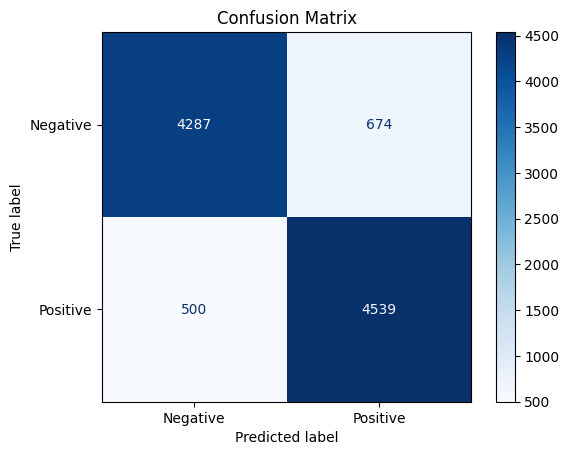

In [26]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')  # 'Blues' is an optional color scheme
plt.title('Confusion Matrix')
plt.show()


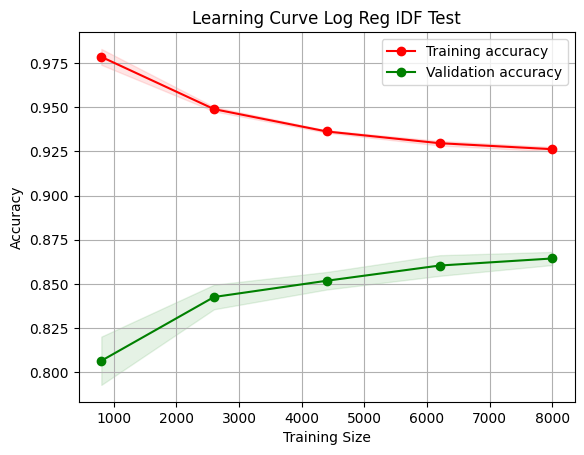

In [27]:
plot_learning_curves(log_reg,
                     X_test_tfidf,
                     y_test,
                     'Learning Curve Log Reg IDF Test',
                     'Training Size',
                     'Accuracy')

Still gap between training and validation, the model could still being overfitting.

# Applying Regularization

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# GridSearch with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(penalty='l2', solver='liblinear'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best C value
print("Best C value:", grid_search.best_params_['C'])

# Best model
best_model = grid_search.best_estimator_


Best C value: 1


In [29]:
# Instantiate and train the Logistic Regression model
log_reg_c_0p1 = LogisticRegression(C=1, penalty='l1', solver='liblinear')
log_reg_c_0p1.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_test = log_reg_c_0p1.predict(X_test_tfidf)

accuracy_regression = accuracy_score(y_test, y_pred_test)
print(accuracy_regression)

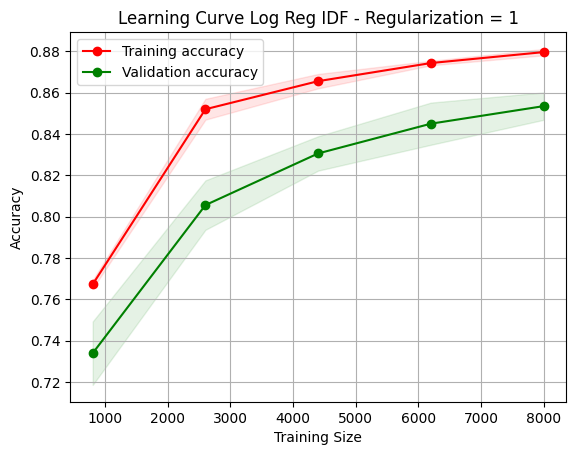

In [30]:
plot_learning_curves(log_reg_c_0p1,
                     X_test_tfidf,
                     y_test,
                     'Learning Curve Log Reg IDF - Regularization = 1',
                     'Training Size',
                     'Accuracy')

The gap has decreased but the accurary has decreased.

# XGBoost

In [31]:
# Instantiate the XGBoost Classifier
xgb_model = XGBClassifier(
    use_label_encoder=False,  # Disable label encoding (newer versions of XGBoost)
    eval_metric='logloss',   # Evaluation metric for binary classification
    random_state=42,         # Ensure reproducibility
    n_estimators=100,        # Number of trees in the ensemble
    learning_rate=0.1,       # Learning rate (can tune this)
    max_depth=6,             # Maximum depth of trees
    subsample=0.8,           # Fraction of samples used for training each tree
    colsample_bytree=0.8     # Fraction of features used for training each tree
)

# Train the model
xgb_model.fit(X_train_tfidf, y_train_encoded)

# Make predictions
y_pred = xgb_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))

# Optional: Create a confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8285

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      4961
           1       0.81      0.87      0.84      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000


Confusion Matrix:
[[3910 1051]
 [ 664 4375]]


In [32]:
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.5.2
#import os
#os.kill(os.getpid(), 9)

In [33]:
import sklearn
import xgboost
print("scikit-learn version:", sklearn.__version__)
print("xgboost version:", xgboost.__version__)

scikit-learn version: 1.5.2
xgboost version: 2.1.3


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the model
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_tfidf, y_train_encoded)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)



Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSerachCV above is very time consuming. It only analyses the combination entered, it requires a pre assessment of what parameters and the related ranges are most relevant for improving the model perfomance.

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='weight')
plt.title("Feature Importance")
plt.show()


# CounterVectorizer versus TF-IDF

In [ ]:
print("Accuracy CV:", accuracy_CV)
print("\nClassification Report CV:\n", classification_rep_CV)
print("\nAccuracy IDF:", accuracy_IDF)
print("\nClassification Report IDF:\n", classification_rep_IDF)